In [1]:
import numpy as np
import scipy as sp
from epymorph.kit import *

In [2]:
from epymorph.params import ParamFunctionNumpy


class UniformPrior:
    def __init__(self, lower, upper):
        self.lower = lower
        self.upper = upper

    def sample(self, size, rng):
        return sp.stats.uniform.rvs(
            loc=self.lower, scale=(self.upper - self.lower), size=size, random_state=rng
        )


class GBM(ParamFunctionNumpy):
    def __init__(self, initial, voliatility):
        self.initial = initial
        self.voliatility = voliatility
        super().__init__()

    def evaluate(self):
        result = np.zeros(shape=(self.time_frame.days, self.scope.nodes))
        result[0, :] = self.initial.sample(self.scope.nodes, self.rng)
        for i in range(self.time_frame.days - 1):
            result[i + 1, :] = np.exp(
                self.rng.normal(np.log(result[i, :]), self.voliatility)
            )
        return result

In [ ]:
from epymorph.adrio import acs5
from epymorph import *  # noqa: F403
from epymorph.geography.us_census import StateScope
from epymorph.data.ipm.sirh import SIRH
from epymorph.data.mm.no import No
from epymorph.initializer import Proportional
from epymorph.rume import SingleStrataRUME
from epymorph.time import TimeFrame


In [4]:
duration = 7 * 53 + 1
t = np.arange(0, duration)
true_beta = 0.03 * np.cos(t * 2 * np.pi / (365)) + 0.28

rume = SingleStrataRUME.build(
    ipm=SIRH(),
    mm=No(),
    scope=StateScope.in_states(["AZ"], year=2015),
    init=Proportional(ratios=np.array([9999, 1, 0, 0], dtype=np.int64)),
    time_frame=TimeFrame.of("2022-10-01", duration),
    params={
        "beta": GBM(initial=UniformPrior(lower=0.4, upper=0.41), voliatility=0.01),
        "gamma": 0.25,
        "xi": 1 / 365,  # 0.0111,
        "hospitalization_prob": 0.01,
        "hospitalization_duration": 5.0,
        "population": acs5.Population(),
    },
)

In [10]:
from types import SimpleNamespace
from typing import Callable, Generic, Optional
from epymorph.attribute import NamePattern
from epymorph.parameter_fitting.filter.particle import Particle
from epymorph.simulation import ParamValue
from epymorph.simulator.basic.basic_simulator import RUMEType
from epymorph.util import CovariantMapping


class ForecastSimulator(Generic[RUMEType]):
    rume: RUMEType
    """The RUME we will use for the simulation."""

    def __init__(
        self,
        rume: RUMEType,
        initial_particles: Optional[list[Particle]] = None,
        num_realizations: Optional[int] = None,
    ):
        self.rume = rume

        # Check if initial_particles is None, and generate if num is provided
        if initial_particles is None:
            if num_realizations is None:
                raise ValueError(
                    "Either 'initial_realizations' or 'num_realizations' must be provided."
                )
            else:
                self.num_realizations = num_realizations

    def run(
        self,
        /,
        params: CovariantMapping[str | NamePattern, ParamValue] | None = None,
        rng_factory: Callable[[], np.random.Generator] | None = None,
    ):
        rume = self.rume

        days = rume.time_frame.days
        taus = rume.num_tau_steps
        R = self.num_realizations
        S = days * taus
        N = self.rume.scope.nodes
        C = self.rume.ipm.num_compartments
        E = self.rume.ipm.num_events

        # It's my personal preference to preallocate memory.
        initial = np.empty(shape=(R, N, C), dtype=np.int64)
        compartments = np.empty(shape=(R, S, N, C), dtype=np.int64)
        events = np.empty(shape=(R, S, N, E), dtype=np.int64)

        rng = (rng_factory or np.random.default_rng)()

        dummy_data = self.rume.evaluate_params(rng)

        return_params = {}
        for key in dummy_data.to_dict().keys():
            return_params[str(key)] = np.empty(
                shape=(self.num_realizations,) + dummy_data.get_raw(key).shape,
                dtype=dummy_data.get_raw(key).dtype,
            )

        for i in range(R):
            # The BasicSimulator does not return the evaluated parameters, so instead we
            # precompute the parameters then pass them into the simulator.
            data = self.rume.evaluate_params(override_params=params, rng=rng)
            evaluated_params = dict(
                zip(
                    [str(key) for key in data.to_dict().keys()],
                    [data.get_raw(key) for key in data.to_dict().keys()],
                )
            )

            sim = BasicSimulator(self.rume)

            out = sim.run(params=evaluated_params, rng_factory=(lambda: rng))

            initial[i, ...] = out.initial
            compartments[i, ...] = out.compartments
            events[i, ...] = out.events

            for key in evaluated_params.keys():
                return_params[key][i, ...] = evaluated_params[key]

        return SimpleNamespace(
            rume=self.rume,
            initial=initial,
            compartments=compartments,
            events=events,
            params=return_params,
        )


In [12]:
sim = ForecastSimulator(rume=rume, num_realizations=100)
forecast_output = sim.run(
    # Here is an example of using overrides to do something similar to param_space.
    # params={"beta": GBM(initial=UniformPrior(lower=0.4, upper=0.41), voliatility=0.01)},
    rng_factory=np.random.default_rng,
)

In [13]:
print(forecast_output.initial.shape)
print(forecast_output.compartments.shape)
print(forecast_output.events.shape)
print(forecast_output.params["gpm:all::ipm::beta"].shape)

(100, 1, 4)
(100, 372, 1, 4)
(100, 372, 1, 5)
(100, 372, 1)


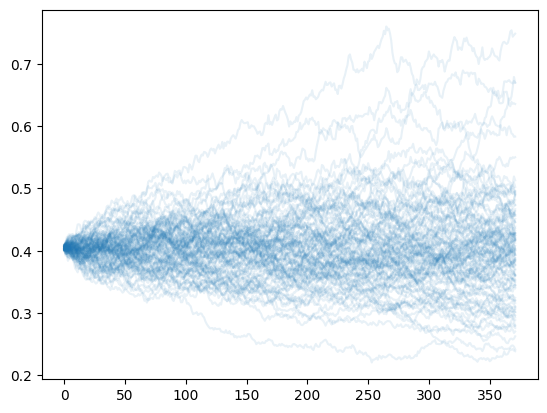

In [14]:
import matplotlib.pyplot as plt

node = 0
plt.plot(
    forecast_output.params["gpm:all::ipm::beta"][:, :, node].T,
    color="tab:blue",
    alpha=0.1,
)
plt.show()

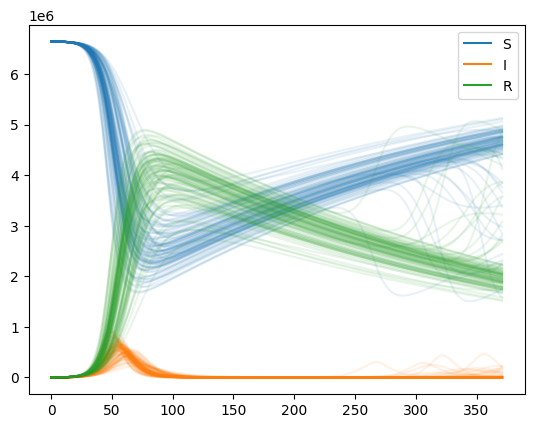

In [15]:
node = 0

plt.plot(forecast_output.compartments[:, :, node, 0].T, color="tab:blue", alpha=0.1)[
    0
].set_label("S")
plt.plot(forecast_output.compartments[:, :, node, 1].T, color="tab:orange", alpha=0.1)[
    0
].set_label("I")
plt.plot(forecast_output.compartments[:, :, node, 2].T, color="tab:green", alpha=0.1)[
    0
].set_label("R")

leg = plt.legend()
for line in leg.get_lines():
    line.set_alpha(1)

plt.show()